# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


# Solution

## Question 1
First let's try to do the request on the https://www.topuniversities.com/university-rankings/world-university-rankings/2018 url just to see what we get.

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
r = requests.get('https://www.topuniversities.com/university-rankings/world-university-rankings/2018')
soup = BeautifulSoup(r.text, 'html.parser')

soup.findAll("td", {"class":"uni"})

[<td class="uni">
 <div class="td-wrap">UNIVERSITY</div>
 </td>, <td class="uni-search uni">
 <div class="td-wrap"></div>
 </td>, <td class="uni-search uni">
 <div class="td-wrap">
 <input class="form-control" placeholder="University search" type="text">
 </input></div>
 </td>]

If we do Ctrl+F and try to look for "Imperial College London" for example, we don't get anything in the Beautifoul soup HTML even if the string is clearly on the webpage. This is because the data is not loaded at the beginning when the HTML request is answered. It is loaded later and the ranking data is in a separate file. Using Google Chrome Interceptor we figured out the file is at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt. So this is the webpage we will scrape instead of the ranking webpage:

In [3]:
from html import parser
import os

In [4]:
base_url = 'https://www.topuniversities.com/'

# create a subclass and override the handler methods
class QSHTMLParser(parser.HTMLParser):
    def handle_starttag(self, tag, attrs):
        if not hasattr(self, 'array_hrefs'):
            self.array_hrefs = []
        if tag == 'a':
            self.last_tag_url = os.path.join(base_url, attrs[0][1][1:])
            
    def handle_data(self, data):
        self.array_hrefs.append({"url": self.last_tag_url, "name": data})

In [5]:
request_ranking_text_file = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')

In [6]:
# We want to keep track of this for the other ranking where there is no region information:
location_region_dict = {}

json_ranking = request_ranking_text_file.json()
ranking_data = json_ranking['data']

# We have to sort the data based on the ranking because some universities are out of order inside the file
ranking_data.sort(key = lambda x: int(x['overall_rank']))

parser = QSHTMLParser()

for university in ranking_data[:200]:
    parser.feed(university['uni'])
        
basic_data = parser.array_hrefs
for i, university in enumerate(ranking_data[:200]):
    curr_uni = basic_data[i]
    curr_uni['region'] = university['region']
    curr_uni['location'] = university['location']
    curr_uni['rank'] = university['overall_rank']
    if university['location'] not in location_region_dict:
        location_region_dict[university['location']] = university['region']
    
basic_data[0:4]

[{'location': 'United States',
  'name': 'Massachusetts Institute of Technology (MIT) ',
  'rank': '1',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/massachusetts-institute-technology-mit'},
 {'location': 'United States',
  'name': 'Stanford University',
  'rank': '2',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/stanford-university'},
 {'location': 'United States',
  'name': 'Harvard University',
  'rank': '3',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/harvard-university'},
 {'location': 'United States',
  'name': 'California Institute of Technology (Caltech)',
  'rank': '4',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/california-institute-technology-caltech'}]

Now we have the URLs of the first 200 universities. Let's take a closer look et the EPFL detail page:

In [7]:
import re

In [8]:
# this shows how to extract information on faculty and students
# we use epfl as a sample

# set up the soup for epfl
url_epfl = basic_data[11]['url']
request_epfl = requests.get(url_epfl)
soup_epfl = BeautifulSoup(request_epfl.text, 'html.parser')

# crawl it for divs with numbers
div_details = soup_epfl.find_all('div', {"class": "view-academic-data-profile"})[0]
div_details.find_all('div', {"class": "number"})
test_det = div_details.find_all('div', {"class": "number"})

# the divs are ordered we can go through them one by one
number_students = {}
student_values = ["staff_total", "staff_international", "students_total", "students_international"]

for i in range(0, 4):
    number = int(re.sub('[,]', '', test_det[i].get_text()))
    number_students[student_values[i]] = number
number_students

{'staff_international': 1300,
 'staff_total': 1695,
 'students_international': 5896,
 'students_total': 10343}

That's it, the code is maybe a little messy but with some browser inspection we used browser inspection to figure out how the webpage is structured.
Now let us generalize this to all the 200 first universities:

In [9]:
number_students_per_fac = {}
student_values = ["staff_total", "staff_international", "students_total", "students_international"]

for i, data in enumerate(basic_data):
    url = data['url']
    # print("Processing ", i, ": ", url)
    request_uni = requests.get(url)
    soup_uni = BeautifulSoup(request_uni.text, 'html.parser')
    
    div_details = soup_uni.find_all('div', {"class": "view-academic-data-profile"})[0]
    test_det = div_details.find_all('div', {"class": "number"})
    
    number_students = {}
    if len(test_det) == 4:
        for j in range(0, 4):
            number = int(re.sub('[,]', '', test_det[j].get_text()))
            basic_data[i][student_values[j]] = number
            
    number_students_per_fac[url] = number_students

That's it, we have all the data for the number of students. We can convince ourselves that this is right by taking a university at random and visiting the corresponding webpage.

Now we simply construct our dataframe (omitting the urls) and set the rank as the key:

In [10]:
import pandas as pd

In [11]:
basic_data_without_url = [dict(uni) for uni in basic_data]
for uni in basic_data_without_url:
    del uni["url"]

qs_dataframe = pd.DataFrame.from_dict(basic_data_without_url)
qs_dataframe.head(5)

,location,name,rank,region,staff_international,staff_total,students_international,students_total
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0


Let's check if we can use the rank as an index (i.e. are all ranks unique or do some universities share the same rank ?)

In [12]:
qs_dataframe["rank"].is_monotonic_increasing

False

That's a no ! So let's just convert it to a number:

In [13]:
qs_dataframe["rank"] = qs_dataframe["rank"].astype(int)

That's it! There is just one thing we have to noctice here: there are two universities (NYU at index 51 and IISc at index 189) where we do not have the info about the number of students / staff members. And indeed, if we visit the webpages we see that the information is not there.
For NYU we don't have anything so we leave it like that (we will see how to deal with the NaN values depending on the questions later). For ISSc we can see 3 out of the 4 informations on the webpage so we will enter it manually:

In [14]:
qs_dataframe[qs_dataframe.isnull().any(axis=1)]

,location,name,rank,region,staff_international,staff_total,students_international,students_total
51,United States,New York University (NYU),52,North America,NaN,NaN,NaN,NaN
189,India,Indian Institute of Science (IISc) Bangalore,190,Asia,NaN,NaN,NaN,NaN


For NYU we have no idea so we search on wikipedia and see there are 50027 students and 9768 members of the academic staff. If we search their website https://www.nyu.edu/students/communities-and-groups/international-students.html we see that "over 17,000 international students and scholars from over 140 different countries", from which we infer that there are probably approximately 2800 international members of the academic staff and 14200 international students. We assume that the the distribution is the same as the total students/staff, then one person out of six in these 17000 is a member of the academic staff.

As for IISc, we see that one value out of the four is NaN (number of international members of the academic staff). Since there are very few international students, we assume that there are also even fewer members of the academic staff. We set the number to 0.

In [15]:
qs_dataframe = qs_dataframe.set_value(51, 'staff_international', 2800).set_value(51, 'staff_total', 9768).set_value(51, 'students_international', 14200).set_value(51, 'students_total', 50027)
qs_dataframe = qs_dataframe.set_value(189, 'staff_international', 0).set_value(189, 'staff_total', 423).set_value(189, 'students_international', 47).set_value(189, 'students_total', 4071)

(Here we did it manually because there were only two universities which were problematic. Of course, if those cases were more frequent then we would need an "automatic" solution for all of them)

In [16]:
qs_dataframe.head(5)

,location,name,rank,region,staff_international,staff_total,students_international,students_total
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0


## Question 2
If we want the best universities in terms of ratio staff / students then we do:

In [17]:
%matplotlib inline

In [18]:
qs_dataframe["staff_students_ratio"] = qs_dataframe['staff_total'] / qs_dataframe['students_total']
qs_staff_ratio_20_best = qs_dataframe.sort_values("staff_students_ratio", ascending=False).head(20)
qs_staff_ratio_20_best.head(5)

,location,name,rank,region,staff_international,staff_total,students_international,students_total,staff_students_ratio
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0,0.422616
15,United States,Yale University,16,North America,1708.0,4940.0,2469.0,12402.0,0.398323
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0,0.342292
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0,0.292488
16,United States,Johns Hopkins University,17,North America,1061.0,4462.0,4105.0,16146.0,0.276353


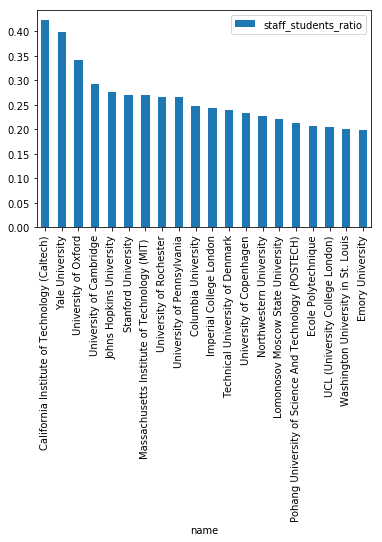

In [19]:
qs_staff_ratio_20_best.plot(kind="bar", x="name", y="staff_students_ratio")

Similarly, if we want the best universities in terms of ratio of international students then we do:

In [20]:
qs_dataframe["intl_students_ratio"] = qs_dataframe['students_international'] / qs_dataframe['students_total']
qs_intl_students_ratio_20_best = qs_dataframe.sort_values("intl_students_ratio", ascending=False).head(20)
qs_intl_students_ratio_20_best.head(5)

,location,name,rank,region,staff_international,staff_total,students_international,students_total,staff_students_ratio,intl_students_ratio
34,United Kingdom,London School of Economics and Political Scien...,35,Europe,687.0,1088.0,6748.0,9760.0,0.111475,0.691393
11,Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Europe,1300.0,1695.0,5896.0,10343.0,0.163879,0.570047
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0,0.244251,0.543567
198,Netherlands,Maastricht University,200,Europe,502.0,1277.0,8234.0,16385.0,0.077937,0.502533
46,United States,Carnegie Mellon University,47,North America,425.0,1342.0,6385.0,13356.0,0.100479,0.478062


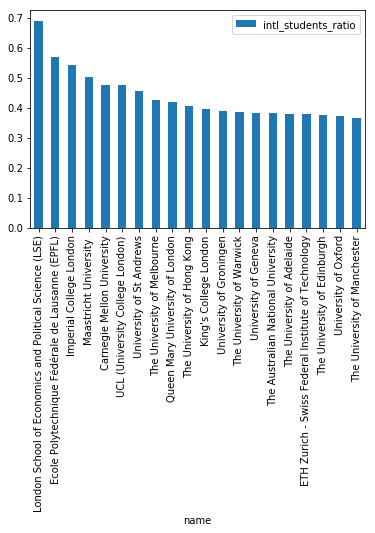

In [21]:
qs_intl_students_ratio_20_best.plot(kind="bar", x="name", y="intl_students_ratio")

### Question 3:

Ratio staff by location:

In [22]:
ratio_staff_location = qs_dataframe.groupby('location')['staff_students_ratio'].mean()
ratio_staff_location

location
Argentina         0.134267
Australia         0.076407
Austria           0.057298
Belgium           0.092131
Brazil            0.079505
Canada            0.103298
Chile             0.070883
China             0.116318
Denmark           0.186580
Finland           0.110731
France            0.144006
Germany           0.098542
Hong Kong         0.128988
India             0.086467
Ireland           0.082180
Israel            0.136047
Italy             0.100247
Japan             0.155840
Malaysia          0.153893
Mexico            0.121204
Netherlands       0.105311
New Zealand       0.068687
Norway            0.122510
Russia            0.221910
Saudi Arabia      0.175828
Singapore         0.162279
South Africa      0.088450
South Korea       0.149356
Spain             0.085209
Sweden            0.104255
Switzerland       0.134872
Taiwan            0.080311
United Kingdom    0.135913
United States     0.152090
Name: staff_students_ratio, dtype: float64

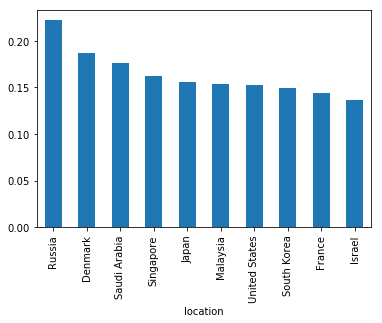

In [23]:
highest_ratio_staff = ratio_staff_location.sort_values(ascending=False).head(10)
highest_ratio_staff.plot.bar()

Ratio staff by region:

In [24]:
ratio_staff_region = qs_dataframe.groupby('region')['staff_students_ratio'].mean()
ratio_staff_region

region
Africa           0.088450
Asia             0.134673
Europe           0.120003
Latin America    0.096779
North America    0.145765
Oceania          0.075003
Name: staff_students_ratio, dtype: float64

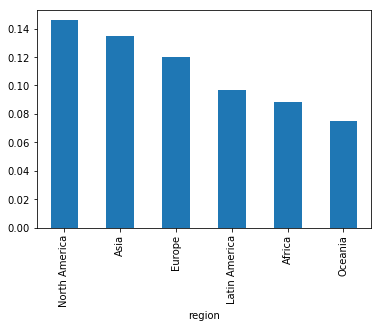

In [25]:
ratio_staff_region.sort_values(ascending=False).head(10).plot.bar()

Ratio international students by location:

In [26]:
ratio_intl_students_location = qs_dataframe.groupby('location')['intl_students_ratio'].mean()
ratio_intl_students_location

location
Argentina         0.221658
Australia         0.346878
Austria           0.306095
Belgium           0.160108
Brazil            0.034050
Canada            0.252604
Chile             0.045816
China             0.107560
Denmark           0.164809
Finland           0.102890
France            0.213286
Germany           0.165300
Hong Kong         0.312148
India             0.010712
Ireland           0.241791
Israel            0.062549
Italy             0.120418
Japan             0.090000
Malaysia          0.194168
Mexico            0.060436
Netherlands       0.245456
New Zealand       0.248971
Norway            0.111379
Russia            0.168624
Saudi Arabia      0.163742
Singapore         0.277091
South Africa      0.169703
South Korea       0.102453
Spain             0.121967
Sweden            0.167998
Switzerland       0.313816
Taiwan            0.091680
United Kingdom    0.351308
United States     0.196697
Name: intl_students_ratio, dtype: float64

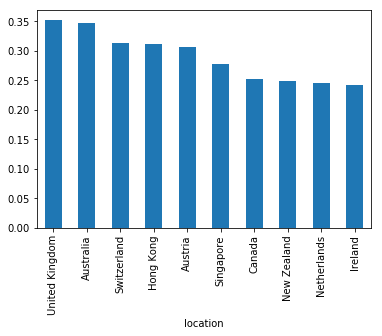

In [27]:
ratio_intl_students_location.sort_values(ascending=False).head(10).plot.bar()

Ratio international students by region:

In [28]:
ratio_intl_students_region = qs_dataframe.groupby('region')['intl_students_ratio'].mean()
ratio_intl_students_region

region
Africa           0.169703
Asia             0.132394
Europe           0.245932
Latin America    0.071751
North America    0.203944
Oceania          0.329077
Name: intl_students_ratio, dtype: float64

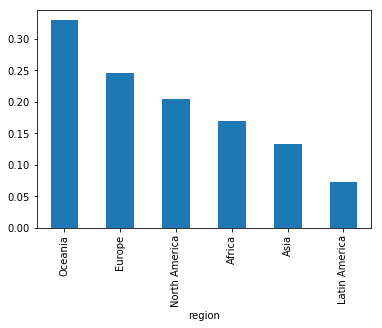

In [29]:
ratio_intl_students_region.sort_values(ascending=False).head(10).plot.bar()

## Times Ranking
Now let's try to request the page for Times ranking:

In [30]:
r_times = requests.get('https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats')
soup_times = BeautifulSoup(r_times.text, 'html.parser')

# again, the website doesn't contain the data we need.
# for example, the univerty of Taiwan is within the 200 best-ranked universities
# but its name is not present in the soup text
"National Taiwan University" in soup_times.text

False

If we display the whole text and do Ctrl + F for "Oxford", we find only the Oxford in the title paragraph explaining the ranking but not the one from the ranking itself. And we do the same thing we did for the QS ranking: we use interceptor and we get all the data on 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [31]:
import json
r_times_ranking = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
data_times_200_first = r_times_ranking.json()['data'][:200]

# this is how an entry looks
data_times_200_first[1]

{'aliases': 'University of Cambridge',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Cambridge',
 'nid': 470,
 'rank': '2',
 'rank_order': '20',
 'record_type': 'master_account',
 'scores_citations': '97.5',
 'scores_citations_rank': '29',
 'scores_industry_income': '51.5',
 'scores_industry_income_rank': '260',
 'scores_international_outlook': '93.0',
 'scores_international_outlook_rank': '35',
 'scores_overall': '93.2',
 'scores_overall_rank': '20',
 'scores_research': '97.8',
 'scores_research_rank': '3',
 'scores_teaching': '87.8',
 'scores_teaching_rank': '3',
 'stats_female_male_ratio': '45 : 55',
 'stats_number_students': '18,389',
 'stats_pc_intl_students': '35%',
 'stats_student_staff_ratio': '10.9',
 'subjects_offered': 'Archaeology,Architecture,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Civil Engineering,Computer Science,Economics & Econometrics,Education,Electrical & Electronic Engineering,Gene

Now we have all the data in our 'data_times_200_first' dictionary. Let's convert that to a pandas frame:

In [32]:
import pandas as pd
times_dataframe = pd.DataFrame.from_dict(data_times_200_first)

Let's take a look at our data frame:

In [33]:
times_dataframe.head(5)

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


We see there are a lot of columns:

In [34]:
print("There are {} columns: {}".format(times_dataframe.shape[1], times_dataframe.columns))

There are 26 columns: Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')


We don't need all those columns. The ones we need are the location, the name, the rank and the stats at the end. We notice here that we don't have access to the region but only the location. We also notice that there is no information concerning the number of international 

In [35]:
times_dataframe = times_dataframe[['location', 'name', 'rank', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']]

Let's first rename a few columns to be consistent with the QS ranking

In [36]:
times_dataframe.rename(columns={'stats_number_students': 'students_total', 'stats_pc_intl_students': 'intl_students_ratio'}, inplace=True)

And let's convert the percentages to ratios:

In [37]:
times_dataframe["students_total"] = times_dataframe["students_total"].map(lambda number : number.replace(",", "")).astype(int)
times_dataframe["intl_students_ratio"] = (times_dataframe["intl_students_ratio"].map(lambda percentage : percentage[:-1]).astype(int) / 100)
times_dataframe["students_international"] = (times_dataframe["students_total"] * (times_dataframe["intl_students_ratio"])).astype(int)

We have to do a few other things here. We see that there is no region column so we have to add a column for that (we know the region because it was already in the QS dataframe):

In [38]:
times_dataframe["region"] = times_dataframe.location.map(location_region_dict)

Unfortunately there are a few locations that were not present in the QS ranking since the 2 rankings are different:

In [39]:
times_dataframe[times_dataframe.region.isnull()]

,location,name,rank,students_total,intl_students_ratio,stats_student_staff_ratio,students_international,region
178,Luxembourg,University of Luxembourg,=179,4969,0.57,14.6,2832,NaN
193,Russian Federation,Lomonosov Moscow State University,194,29236,0.22,7.3,6431,NaN


So let's correct that:

In [40]:
times_dataframe = times_dataframe.set_value(178, "region", "Europe").set_value(193, "region", "Europe")

We can also convert the rank column to numbers, while taking into accounts the values with an equal sign "="

In [41]:
times_dataframe["rank"] = times_dataframe["rank"].map(lambda rank : rank.replace("=", "")).astype(int)

And last thing also: there is a students staff ratio number. We can obviously infer the total number of academic staff members from this. Unfortunately, there is no way to know the number of international staff members so we will somehow try to approximate it: we will simply use the percentage of international students and apply it to the total number of staff members. We know this is not the reality but we need some values and also we will have an opportunity to check the validity of this number later when we will compute the correlations between the two rankings.

In [42]:
times_dataframe["staff_total"] = (times_dataframe["students_total"] / times_dataframe["stats_student_staff_ratio"].astype(float)).astype(int)
times_dataframe["staff_international"] = (times_dataframe["staff_total"] * (times_dataframe["intl_students_ratio"])).astype(int)

### Aggregations by region and location
Let's repeat the same things as for the QS ranking

First sorting the dataframe according to ratio students staff. Here we do not need to compute it since it is already given:

In [43]:
times_dataframe["stats_student_staff_ratio"] = times_dataframe["stats_student_staff_ratio"].astype(float)
times_dataframe_ratio_staff = times_dataframe.sort_values('stats_student_staff_ratio')
times_dataframe_ratio_staff.head(5)

,location,name,rank,students_total,intl_students_ratio,stats_student_staff_ratio,students_international,region,staff_total,staff_international
105,United States,Vanderbilt University,105,12011,0.13,3.3,1561,North America,3639,473
109,Denmark,University of Copenhagen,109,30395,0.14,4.1,4255,Europe,7413,1037
12,United States,Johns Hopkins University,13,15498,0.24,4.3,3719,North America,3604,864
11,United States,Yale University,12,12155,0.21,4.3,2552,North America,2826,593
153,United States,University of Rochester,153,9636,0.29,4.3,2794,North America,2240,649


Ration of international students:

In [44]:
times_dataframe_intl_students_ratio = times_dataframe.sort_values('intl_students_ratio', ascending=False)
times_dataframe_intl_students_ratio.head(5)

,location,name,rank,students_total,intl_students_ratio,stats_student_staff_ratio,students_international,region,staff_total,staff_international
24,United Kingdom,London School of Economics and Political Science,25,10065,0.71,12.2,7146,Europe,825,585
178,Luxembourg,University of Luxembourg,179,4969,0.57,14.6,2832,Europe,340,193
37,Switzerland,École Polytechnique Fédérale de Lausanne,38,9928,0.55,11.2,5460,Europe,886,487
7,United Kingdom,Imperial College London,8,15857,0.55,11.4,8721,Europe,1390,764
102,Netherlands,Maastricht University,103,16727,0.50,18.0,8363,Europe,929,464


Ratio staff by location:

In [45]:
ratio_staff_location = times_dataframe_ratio_staff.groupby('location')['stats_student_staff_ratio'].mean()
ratio_staff_location

location
Australia             27.462500
Austria               20.800000
Belgium               38.550000
Canada                19.716667
China                 11.942857
Denmark                8.133333
Finland               18.200000
France                13.450000
Germany               44.025000
Hong Kong             19.300000
Ireland               22.800000
Italy                  8.450000
Japan                  7.700000
Luxembourg            14.600000
Netherlands           18.330769
New Zealand           18.800000
Norway                18.600000
Russian Federation     7.300000
Singapore             16.650000
South Africa          11.700000
South Korea           13.300000
Spain                 16.850000
Sweden                15.200000
Switzerland           13.514286
Taiwan                11.500000
United Kingdom        13.661290
United States         11.904839
Name: stats_student_staff_ratio, dtype: float64

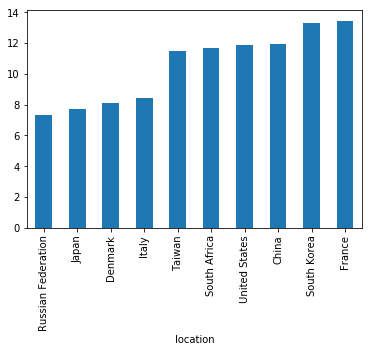

In [46]:
ratio_staff_location.sort_values().head(10).plot.bar()

Ratio staff by region:

In [47]:
ratio_staff_region = times_dataframe_ratio_staff.groupby('region')['intl_students_ratio'].mean()
ratio_staff_region

region
Africa           0.180000
Asia             0.165238
Europe           0.244653
North America    0.185588
Oceania          0.305556
Name: intl_students_ratio, dtype: float64

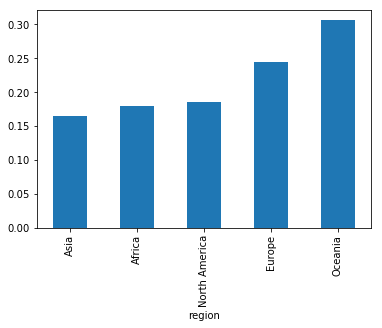

In [48]:
ratio_staff_region.sort_values().head().plot.bar()

Ratio international students by location:

In [49]:
intl_students_ratio_location = times_dataframe_intl_students_ratio.groupby('location')['intl_students_ratio'].mean()
intl_students_ratio_location

location
Australia             0.307500
Austria               0.260000
Belgium               0.197500
Canada                0.225000
China                 0.085714
Denmark               0.166667
Finland               0.130000
France                0.208333
Germany               0.152000
Hong Kong             0.328000
Ireland               0.270000
Italy                 0.105000
Japan                 0.090000
Luxembourg            0.570000
Netherlands           0.192308
New Zealand           0.290000
Norway                0.190000
Russian Federation    0.220000
Singapore             0.305000
South Africa          0.180000
South Korea           0.090000
Spain                 0.140000
Sweden                0.140000
Switzerland           0.314286
Taiwan                0.080000
United Kingdom        0.365484
United States         0.181774
Name: intl_students_ratio, dtype: float64

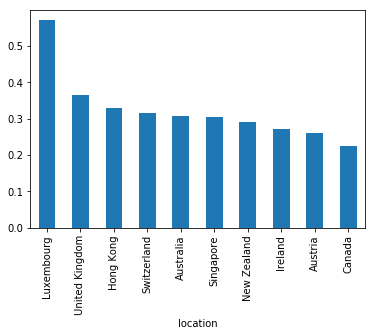

In [50]:
intl_students_ratio_location.sort_values(ascending=False).head(10).plot.bar()

Ratio international students by region:

In [51]:
intl_students_ratio_region = times_dataframe_intl_students_ratio.groupby('region')['intl_students_ratio'].mean()
intl_students_ratio_region

region
Africa           0.180000
Asia             0.165238
Europe           0.244653
North America    0.185588
Oceania          0.305556
Name: intl_students_ratio, dtype: float64

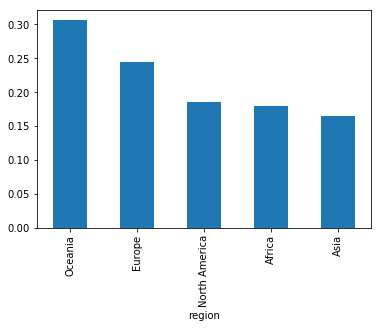

In [52]:
intl_students_ratio_region.sort_values(ascending=False).head().plot.bar()

## Joining the two dataframes

Now we would like to do a join of the two rankings by university names. So let's try the naive approach:

In [70]:
times_dataframe.merge(qs_dataframe, on="name").head(5)

,location_x,name,rank_x,students_total_x,intl_students_ratio_x,stats_student_staff_ratio,students_international_x,region_x,staff_total_x,staff_international_x,location_y,rank_y,region_y,staff_international_y,staff_total_y,students_international_y,students_total_y,staff_students_ratio,intl_students_ratio_y
0,United Kingdom,University of Oxford,1,20409,0.38,11.2,7755,Europe,1822,692,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0,0.342292,0.372870
1,United Kingdom,University of Cambridge,2,18389,0.35,10.9,6436,Europe,1687,590,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899
2,United States,Stanford University,3,15845,0.22,7.5,3485,North America,2112,464,United States,2,North America,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422
3,United States,Harvard University,6,20326,0.26,8.9,5284,North America,2283,593,United States,3,North America,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785
4,United States,Princeton University,7,7955,0.24,8.3,1909,North America,958,229,United States,13,North America,246.0,1007.0,1793.0,8069.0,0.124799,0.222208


There are only 104 of them but there is a problem here. Some universities might not have the same name in both dataframes. Take for example MIT. In the QS ranking it is "Massachusetts Institute of Technology (MIT)" but in the Times ranking it is "Massachusetts Institute of Technology". So they do not match in the above frame. Thus we need a way to measure strings similarity between the names of the universities.

In [54]:
from difflib import get_close_matches
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()

# print the matchings for inspection
# you can print the whole list
#for name in list_qs_names:
#    closest_matches = get_close_matches(name, list_times_names)
#    print("Closest matches to {} are {}".format(name, closest_matches))

# for this notebook we just show one sample
name = list_qs_names[0]
closest_matches = get_close_matches(name, list_times_names)
print("Closest matches to {} are {}".format(name, closest_matches))


Closest matches to Massachusetts Institute of Technology (MIT)  are ['Massachusetts Institute of Technology', 'Karlsruhe Institute of Technology', 'Georgia Institute of Technology']


So here we have a list of closest matches from the Times ranking to the names in the QS ranking. However, there are some names for which none of the given matches correspond to the name (simply because the university is not present in both rankings). Let's take a look at the score for the highest match in each case:

In [55]:
from difflib import get_close_matches, SequenceMatcher
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()

count = 5
for name in list_qs_names:
    closest_matches = get_close_matches(name, list_times_names)
    print("Closest matches to {} are {}".format(name, closest_matches))
    if(len(closest_matches) > 0):
        best_match = closest_matches[0]
        score = SequenceMatcher(None, name, best_match).ratio()
        print("Score of best match is {}".format(score))
        
    count -= 1
    if count == 0:
        break

Closest matches to Massachusetts Institute of Technology (MIT)  are ['Massachusetts Institute of Technology', 'Karlsruhe Institute of Technology', 'Georgia Institute of Technology']
Score of best match is 0.9135802469135802
Closest matches to Stanford University are ['Stanford University', 'Lund University', 'Harvard University']
Score of best match is 1.0
Closest matches to Harvard University are ['Harvard University', 'Cardiff University', 'Stanford University']
Score of best match is 1.0
Closest matches to California Institute of Technology (Caltech) are ['California Institute of Technology', 'Georgia Institute of Technology', 'Karlsruhe Institute of Technology']
Score of best match is 0.8717948717948718
Closest matches to University of Cambridge are ['University of Cambridge', 'University of Miami', 'University of Tübingen']
Score of best match is 1.0


So here we have to go through the list (there are 200 elements) and to estimate ourselves which is the right "threshold" where we want to keep the matching. Here we will say 0.86. When the score is below that we don't really know whether the two universities are the same or not. For example, there are many universities called "University of California" but sometimes the name is "University of California, San Diego", "University of California, Los Angeles", etc. In all those cases we have a matching score below 0.86 so let's construct the "matching dictionary":

In [56]:
from difflib import get_close_matches, SequenceMatcher
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()

matching_dict = {}
for name in list_qs_names:
    closest_matches = get_close_matches(name, list_times_names)
    if(len(closest_matches) > 0):
        best_match = closest_matches[0]
        score = SequenceMatcher(None, name, best_match).ratio()
        if score > 0.86:
            matching_dict[name] = best_match

In [57]:
count = 5
for key, value in matching_dict.items():
    print(key, " matches, ", value)
    
    count -= 1
    if count == 0:
        break

University of Glasgow  matches,  University of Glasgow
University of Liverpool  matches,  University of Liverpool
The University of Hong Kong  matches,  University of Hong Kong
Princeton University  matches,  Princeton University
Nanyang Technological University, Singapore (NTU)  matches,  Nanyang Technological University, Singapore


Now there is just the "University of York" matching to "University of Tokyo" which is problematic so we will remove it:

In [58]:
del matching_dict["University of York"]

Also, there is one other university which is problematic. The 'City University of Hong Kong' is actually not the same as the 'University of Hong Kong' (Check QS ranking on ranks 26 and 49) so we will remove it too:

In [59]:
del matching_dict["City University of Hong Kong"]

In [60]:
print("There are {} joint universities with our strategy.".format(len(matching_dict)))

There are 147 joint universities with our strategy.


In [61]:
qs_dataframe_rename = qs_dataframe.replace(to_replace={"name": dict((k, v) for k, v in matching_dict.items() if k != v)})
joint_ranking = times_dataframe.merge(qs_dataframe_rename, on="name", suffixes=("_times","_qs"))
joint_ranking.head(5)

,location_times,name,rank_times,students_total_times,intl_students_ratio_times,stats_student_staff_ratio,students_international_times,region_times,staff_total_times,staff_international_times,location_qs,rank_qs,region_qs,staff_international_qs,staff_total_qs,students_international_qs,students_total_qs,staff_students_ratio,intl_students_ratio_qs
0,United Kingdom,University of Oxford,1,20409,0.38,11.2,7755,Europe,1822,692,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0,0.342292,0.372870
1,United Kingdom,University of Cambridge,2,18389,0.35,10.9,6436,Europe,1687,590,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899
2,United States,California Institute of Technology,3,2209,0.27,6.5,596,North America,339,91,United States,4,North America,350.0,953.0,647.0,2255.0,0.422616,0.286918
3,United States,Stanford University,3,15845,0.22,7.5,3485,North America,2112,464,United States,2,North America,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422
4,United States,Massachusetts Institute of Technology,5,11177,0.34,8.7,3800,North America,1284,436,United States,1,North America,1679.0,2982.0,3717.0,11067.0,0.269450,0.335863


## Exploratory data analysis:
Here we want to see what information we can get by computing multiple correlations between the columns of our joint frame. First, let's see what we get if we try to compute the rank correlation:

In [62]:
print("The correlation between the two rankings is {}".format(joint_ranking["rank_times"].corr(joint_ranking["rank_qs"])))

The correlation between the two rankings is 0.6926775371685369


So it is almost 0.7. This number can be interpreted in multiple ways. We can say that it is far from 0, the two rankings have a lot of universities in common and the rankings "look alike" in a way. However, it is also far from 0.9 so we can conclude that the methods used for computing a university's rank are quite different. 

Now let's do the same comparison for the other columns:

Populating the interactive namespace from numpy and matplotlib


C:\Users\lhk\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


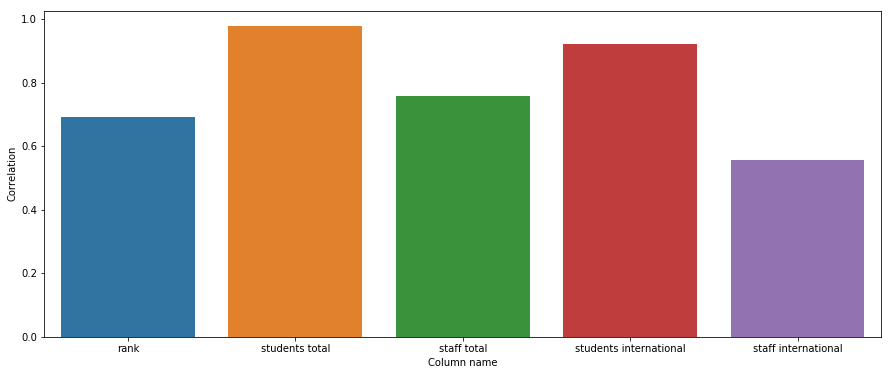

In [63]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

import matplotlib.pyplot as plt
import seaborn as sns

corr_columns_names = ["rank", "students_total", "staff_total", "students_international", "staff_international"]
corr_columns = [(name + "_qs", name + "_times") for name in corr_columns_names]
#corr_columns = [("rank_x", "rank_y"), ("students_total_x", "students_total_y"), ("staff_total_x", "staff_total_y"),
#               ("students_international_x", "students_international_y"), ("staff_international_x", "staff_international_y")]
col_names = []
corrs = []
for col1, col2 in corr_columns:
    corr = joint_ranking[col1].corr(joint_ranking[col2])
    if col1.startswith("rank"):
        col_name = "rank"
    else:
        col_name = col1.split("_")[0] + " " + col1.split("_")[1]
    
    col_names.append(col_name)
    corrs.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x=col_names, y=corrs, ax=ax)
ax.set(xlabel="Column name", ylabel="Correlation")
plt.show()

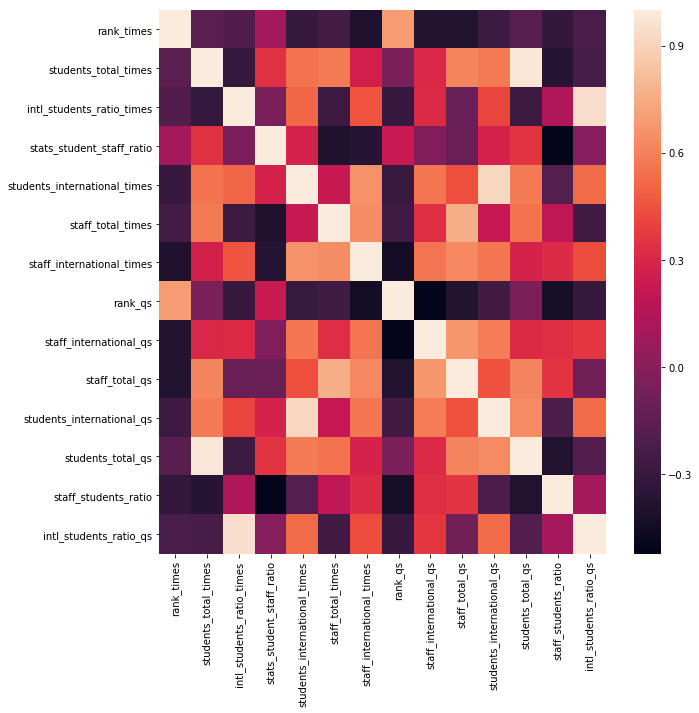

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(joint_ranking.corr())

Here we see that the correlations for the number of students are almost 1 (especially the total number of students). The correlation for the international number of students is a little above 0.9 so we can conclude that the method of determining which student is "international" can be different in both cases sometimes even if, overall, it is approximately the same thing since it is almost 1.

However, the correlation numbers are quite low for the staff columns and especially for the international staff column. We see that for the total number of staff members it is a little above 0.75 so we can conclude that the two rankings did not choose that someone belongs to the staff category by the same criteria. Even worse, the international staff correlation is just a little above 0.55. We recall that this information was not present for the Times ranking so we created it using the ratio of international students and "hoping" it would give some precise results. Here we see it is not the case.

Now let's compare the rank in a ranking with all the other stats about students and staff numbers:

In [65]:
joint_ranking["staff_students_ratio_times"] = joint_ranking["stats_student_staff_ratio"].map(lambda number: 1 / number)
joint_ranking["staff_students_ratio_qs"] = joint_ranking["staff_total_qs"] / joint_ranking["students_total_qs"]
joint_ranking["intl_staff_ratio_times"] = joint_ranking["staff_international_times"] / joint_ranking["staff_total_times"]
joint_ranking["intl_staff_ratio_qs"] = joint_ranking["staff_international_qs"] / joint_ranking["staff_total_qs"]
joint_ranking = joint_ranking[["name", "region_times", "location_times", "rank_times", "students_total_times", "students_international_times", "staff_total_times", "staff_international_times", "staff_students_ratio_times", "intl_students_ratio_times", "intl_staff_ratio_times",
                                       "region_qs", "location_qs", "rank_qs", "students_total_qs", "students_international_qs", "staff_total_qs", "staff_international_qs", "staff_students_ratio_qs", "intl_students_ratio_qs", "intl_staff_ratio_qs"]]
joint_ranking["rank_times"] = pd.to_numeric(joint_ranking["rank_times"])
joint_ranking["rank_qs"] = pd.to_numeric(joint_ranking["rank_qs"])

Times ranking:

Populating the interactive namespace from numpy and matplotlib
students_total_times : -0.16055101632458857
students_international_times : -0.3010494996991297
staff_total_times : -0.25163196292451223
staff_international_times : -0.3943962014424919
staff_students_ratio_times : -0.1426287473684651
intl_students_ratio_times : -0.2061463777045013
intl_staff_ratio_times : -0.20742184499670646


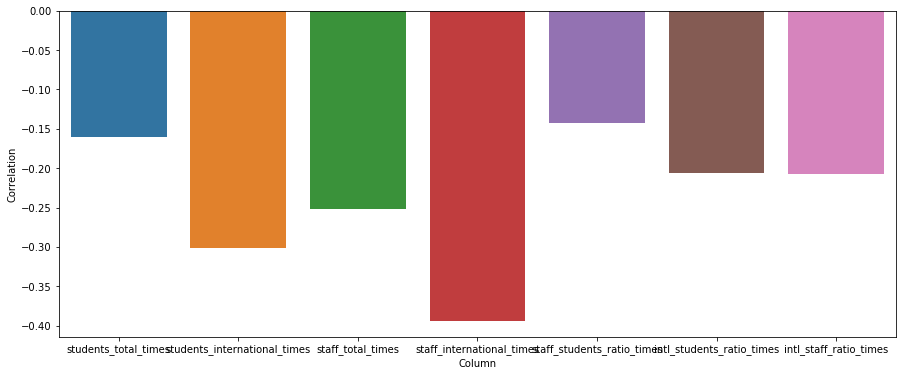

In [66]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

corr_cols = ["students_total_times", "students_international_times", "staff_total_times", "staff_international_times", "staff_students_ratio_times", "intl_students_ratio_times", "intl_staff_ratio_times"]
corrs_qs_rank = []
for col in corr_cols:
    corr = joint_ranking["rank_times"].corr(joint_ranking[col])
    print("{} : {}".format(col, corr))
    corrs_qs_rank.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x = corr_cols, y = corrs_qs_rank, ax=ax)
ax.set(xlabel="Column", ylabel="Correlation")
plt.show()

QS Ranking:

Populating the interactive namespace from numpy and matplotlib
students_total_qs : -0.04324109113777754
students_international_qs : -0.25797834629866184
staff_total_qs : -0.38301031588398343
staff_international_qs : -0.5072337235517727
staff_students_ratio_qs : -0.4300870294119145
intl_students_ratio_qs : -0.29842916438079525
intl_staff_ratio_qs : -0.29120815630072755


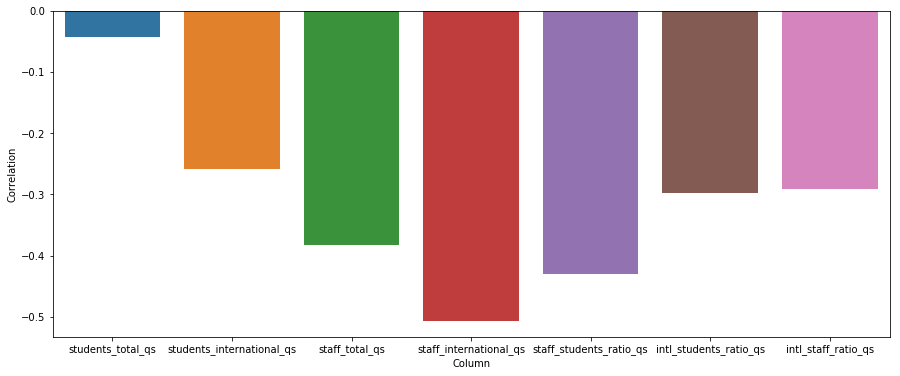

In [67]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

corr_cols = ["students_total_qs", "students_international_qs", "staff_total_qs", "staff_international_qs", "staff_students_ratio_qs", "intl_students_ratio_qs", "intl_staff_ratio_qs"]
corrs_qs_rank = []
for col in corr_cols:
    corr = joint_ranking["rank_qs"].corr(joint_ranking[col])
    print("{} : {}".format(col, corr))
    corrs_qs_rank.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x = corr_cols, y = corrs_qs_rank, ax=ax)
ax.set(xlabel="Column", ylabel="Correlation")
plt.show()

### Discussion
Here we see that all those correlations are negative for both rankings. The reason is simply because the ranking is in ascending order. The total number of students has a quite weak correlation with the ranking (even if there is some, we can say that the number of students is not an indicator of the ranking). However, the ratio of international students and staff members both show a stronger correlation than the number of students. This could mean that universities which are better in ranking attract more people from other countries. Now, the total number of staff members also shows a stronger correlation, which indicates that universities which are better in ranking have more people (probably more money also). Similar conclusions can be drawn for international staff members.

In [68]:
joint_ranking.students_total_times.corr(joint_ranking.students_total_qs)

0.978373688007668

# Question 5
The idea for finding the best university is, if put in one word: consistency. The idea is the following: a university is good if it's good in both rankings.

For example, if university A is first in QS but last in Times, and university B is second in both rankings, clearly we would choose university B as a better one !

The method we chose to measure consistency is simply the mean of the rankings. A lower mean means that the ranking is low in both rankings.

In [69]:
joint_ranking["rank_mean"] = ((joint_ranking["rank_qs"] + joint_ranking["rank_times"]) / 2)
joint_ranking.sort_values("rank_mean").head()

,name,region_times,location_times,rank_times,students_total_times,students_international_times,staff_total_times,staff_international_times,staff_students_ratio_times,intl_students_ratio_times,...,location_qs,rank_qs,students_total_qs,students_international_qs,staff_total_qs,staff_international_qs,staff_students_ratio_qs,intl_students_ratio_qs,intl_staff_ratio_qs,rank_mean
3,Stanford University,North America,United States,3,15845,3485,2112,464,0.133333,0.22,...,United States,2,15878.0,3611.0,4285.0,2042.0,0.269870,0.227422,0.476546,2.5
4,Massachusetts Institute of Technology,North America,United States,5,11177,3800,1284,436,0.114943,0.34,...,United States,1,11067.0,3717.0,2982.0,1679.0,0.269450,0.335863,0.563045,3.0
0,University of Oxford,Europe,United Kingdom,1,20409,7755,1822,692,0.089286,0.38,...,United Kingdom,6,19720.0,7353.0,6750.0,2964.0,0.342292,0.372870,0.439111,3.5
1,University of Cambridge,Europe,United Kingdom,2,18389,6436,1687,590,0.091743,0.35,...,United Kingdom,5,18770.0,6699.0,5490.0,2278.0,0.292488,0.356899,0.414936,3.5
2,California Institute of Technology,North America,United States,3,2209,596,339,91,0.153846,0.27,...,United States,4,2255.0,647.0,953.0,350.0,0.422616,0.286918,0.367261,3.5


_Stanford_ is the best university !

Note: if we had two universities with the same mean in the first place, a strategy to discriminate them would be to choose the one which has the best "min ranking"

For example: if university A has rankings 1 and 3, and university B has rankings 2 and 2, we would choose A because it has one lower ranking with value 1